# FloPy

### ZoneBudget Example

This notebook demonstrates how to use the `ZoneBudget` class to extract budget information from the cell by cell budget file using an array of zones.

First set the path and import the required packages. The flopy path doesn't have to be set if you install flopy from a binary installer. If you want to run this notebook, you have to set the path to your own flopy path.

In [1]:
import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('pandas version: {}'.format(pd.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in /Users/jdhughes/Documents/Development/flopy_git/flopy_fork/flopy
3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 14:38:56) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.17.3
matplotlib version: 3.1.1
pandas version: 0.25.2
flopy version: 3.3.0


In [2]:
# Set path to example datafiles
loadpth = os.path.join('..', 'data', 'zonbud_examples')
cbc_f = os.path.join(loadpth, 'freyberg.gitcbc')

### Read File Containing Zones
Using the `read_zbarray` utility, we can import zonebudget-style array files.

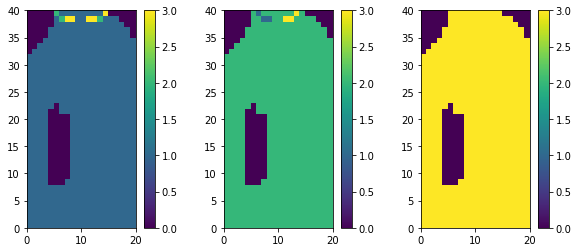

In [3]:
from flopy.utils import read_zbarray

zone_file = os.path.join(loadpth, 'zonef_mlt.zbr')
zon = read_zbarray(zone_file)
nlay, nrow, ncol = zon.shape

fig = plt.figure(figsize=(10, 4))

for lay in range(nlay):
    ax = fig.add_subplot(1, nlay, lay+1)
    im = ax.pcolormesh(zon[lay, :, :])
    cbar = plt.colorbar(im)
    plt.gca().set_aspect('equal')
    
plt.show()

### Extract Budget Information from ZoneBudget Object

At the core of the `ZoneBudget` object is a numpy structured array. The class provides some wrapper functions to help us interogate the array and save it to disk.

In [4]:
# Create a ZoneBudget object and get the budget record array
zb = flopy.utils.ZoneBudget(cbc_f, zon, kstpkper=(0, 1096))
zb.get_budget()

array([(1097., 0, 1096, 'FROM_STORAGE', 0.0000000e+00, 0.0000000e+00, 0.0000000e+00),
       (1097., 0, 1096, 'FROM_CONSTANT_HEAD', 0.0000000e+00, 2.3156659e+02, 8.6217201e+01),
       (1097., 0, 1096, 'FROM_WELLS', 0.0000000e+00, 0.0000000e+00, 0.0000000e+00),
       (1097., 0, 1096, 'FROM_DRAINS', 0.0000000e+00, 0.0000000e+00, 0.0000000e+00),
       (1097., 0, 1096, 'FROM_RECHARGE', 5.1455815e+03, 1.4936376e+01, 2.9872751e+01),
       (1097., 0, 1096, 'FROM_ZONE_0', 0.0000000e+00, 0.0000000e+00, 0.0000000e+00),
       (1097., 0, 1096, 'FROM_ZONE_1', 0.0000000e+00, 3.4751235e+03, 1.3860045e+02),
       (1097., 0, 1096, 'FROM_ZONE_2', 3.2693188e+03, 0.0000000e+00, 1.7646553e+03),
       (1097., 0, 1096, 'FROM_ZONE_3', 1.9218604e+02, 1.5280482e+03, 0.0000000e+00),
       (1097., 0, 1096, 'TOTAL_IN', 8.6070859e+03, 5.2496748e+03, 2.0193457e+03),
       (1097., 0, 1096, 'TO_STORAGE', 0.0000000e+00, 0.0000000e+00, 0.0000000e+00),
       (1097., 0, 1096, 'TO_CONSTANT_HEAD', 2.3054836e+02, 2

In [5]:
# Get a list of the unique budget record names
zb.get_record_names()

array(['FROM_CONSTANT_HEAD', 'FROM_DRAINS', 'FROM_RECHARGE',
       'FROM_STORAGE', 'FROM_WELLS', 'FROM_ZONE_0', 'FROM_ZONE_1',
       'FROM_ZONE_2', 'FROM_ZONE_3', 'IN-OUT', 'PERCENT_DISCREPANCY',
       'TOTAL_IN', 'TOTAL_OUT', 'TO_CONSTANT_HEAD', 'TO_DRAINS',
       'TO_RECHARGE', 'TO_STORAGE', 'TO_WELLS', 'TO_ZONE_0', 'TO_ZONE_1',
       'TO_ZONE_2', 'TO_ZONE_3'], dtype='<U50')

In [6]:
# Look at a subset of fluxes
names = ['FROM_RECHARGE', 'FROM_ZONE_1', 'FROM_ZONE_3']
zb.get_budget(names=names)

array([(1097., 0, 1096, 'FROM_RECHARGE', 5145.5815 ,   14.936376,  29.872751),
       (1097., 0, 1096, 'FROM_ZONE_1',    0.     , 3475.1235  , 138.60045 ),
       (1097., 0, 1096, 'FROM_ZONE_3',  192.18604, 1528.0482  ,   0.      )],
      dtype=[('totim', '<f4'), ('time_step', '<i4'), ('stress_period', '<i4'), ('name', '<U50'), ('ZONE_1', '<f4'), ('ZONE_2', '<f4'), ('ZONE_3', '<f4')])

In [7]:
# Look at fluxes in from zone 2
names = ['FROM_RECHARGE', 'FROM_ZONE_1', 'FROM_ZONE_3']
zones = ['ZONE_2']
zb.get_budget(names=names, zones=zones)

array([(1097., 0, 1096, 'FROM_RECHARGE',   14.936376),
       (1097., 0, 1096, 'FROM_ZONE_1', 3475.1235  ),
       (1097., 0, 1096, 'FROM_ZONE_3', 1528.0482  )],
      dtype={'names':['totim','time_step','stress_period','name','ZONE_2'], 'formats':['<f4','<i4','<i4','<U50','<f4'], 'offsets':[0,4,8,12,216], 'itemsize':224})

In [8]:
# Look at all of the mass-balance records
names = ['TOTAL_IN', 'TOTAL_OUT', 'IN-OUT', 'PERCENT_DISCREPANCY']
zb.get_budget(names=names)

array([(1097., 0, 1096, 'TOTAL_IN', 8.6070859e+03, 5.249675e+03, 2.0193457e+03),
       (1097., 0, 1096, 'TOTAL_OUT', 8.6070723e+03, 5.249676e+03, 2.0193480e+03),
       (1097., 0, 1096, 'IN-OUT', 1.3671875e-02, 9.765625e-04, 2.3193359e-03),
       (1097., 0, 1096, 'PERCENT_DISCREPANCY', 1.5884454e-04, 1.860234e-05, 1.1485574e-04)],
      dtype=[('totim', '<f4'), ('time_step', '<i4'), ('stress_period', '<i4'), ('name', '<U50'), ('ZONE_1', '<f4'), ('ZONE_2', '<f4'), ('ZONE_3', '<f4')])

### Convert Units
The `ZoneBudget` class supports the use of mathematical operators and returns a new copy of the object.

In [9]:
cmd = flopy.utils.ZoneBudget(cbc_f, zon, kstpkper=(0, 0))
cfd = cmd / 35.3147
inyr = (cfd / (250 * 250)) * 365 * 12

cmdbud = cmd.get_budget()
cfdbud = cfd.get_budget()
inyrbud = inyr.get_budget()

names = ['FROM_RECHARGE']
rowidx = np.in1d(cmdbud['name'], names)
colidx = 'ZONE_1'

print('{:,.1f} cubic meters/day'.format(cmdbud[rowidx][colidx][0]))
print('{:,.1f} cubic feet/day'.format(cfdbud[rowidx][colidx][0]))
print('{:,.1f} inches/year'.format(inyrbud[rowidx][colidx][0]))

6,222.7 cubic meters/day
176.2 cubic feet/day
12.3 inches/year


In [10]:
cmd is cfd

False

### Alias Names
A dictionary of {zone: "alias"} pairs can be passed to replace the typical "ZONE_X" fieldnames of the `ZoneBudget` structured array with more descriptive names.

In [11]:
aliases = {1: 'SURF', 2:'CONF', 3: 'UFA'}
zb = flopy.utils.ZoneBudget(cbc_f, zon, totim=[1097.], aliases=aliases)
zb.get_budget()

array([(1097., 0, 1096, 'FROM_STORAGE', 0.0000000e+00, 0.0000000e+00, 0.0000000e+00),
       (1097., 0, 1096, 'FROM_CONSTANT_HEAD', 0.0000000e+00, 2.3156659e+02, 8.6217201e+01),
       (1097., 0, 1096, 'FROM_WELLS', 0.0000000e+00, 0.0000000e+00, 0.0000000e+00),
       (1097., 0, 1096, 'FROM_DRAINS', 0.0000000e+00, 0.0000000e+00, 0.0000000e+00),
       (1097., 0, 1096, 'FROM_RECHARGE', 5.1455815e+03, 1.4936376e+01, 2.9872751e+01),
       (1097., 0, 1096, 'FROM_ZONE_0', 0.0000000e+00, 0.0000000e+00, 0.0000000e+00),
       (1097., 0, 1096, 'FROM_SURF', 0.0000000e+00, 3.4751235e+03, 1.3860045e+02),
       (1097., 0, 1096, 'FROM_CONF', 3.2693188e+03, 0.0000000e+00, 1.7646553e+03),
       (1097., 0, 1096, 'FROM_UFA', 1.9218604e+02, 1.5280482e+03, 0.0000000e+00),
       (1097., 0, 1096, 'TOTAL_IN', 8.6070859e+03, 5.2496748e+03, 2.0193457e+03),
       (1097., 0, 1096, 'TO_STORAGE', 0.0000000e+00, 0.0000000e+00, 0.0000000e+00),
       (1097., 0, 1096, 'TO_CONSTANT_HEAD', 2.3054836e+02, 2.157015

### Return the Budgets as a Pandas DataFrame
Set `kstpkper` and `totim` keyword args to `None` (or omit) to return all times.
The `get_dataframes()` method will return a DataFrame multi-indexed on `totim` and `name`.

In [12]:
aliases = {1: 'SURF', 2:'CONF', 3: 'UFA'}
times = list(range(1092, 1097+1))
zb = flopy.utils.ZoneBudget(cbc_f, zon, totim=times, aliases=aliases)
zb.get_dataframes()

SURF         CONF          UFA
totim  name                                                      
1092.0 FROM_STORAGE          393.480286   230.476242   228.273621
       FROM_CONSTANT_HEAD      0.000000    13.225761     5.042325
       FROM_WELLS              0.000000     0.000000     0.000000
       FROM_DRAINS             0.000000     0.000000     0.000000
       FROM_RECHARGE        6018.483887    17.470200    34.940399
...                                 ...          ...          ...
1097.0 TO_CONF              3475.123535     0.000000  1528.048218
       TO_UFA                138.600449  1764.655273     0.000000
       TOTAL_OUT            8607.072266  5249.675781  2019.348022
       IN-OUT                  0.013672     0.000977     0.002319
       PERCENT_DISCREPANCY     0.000159     0.000019     0.000115

[132 rows x 3 columns]

Slice the multi-index dataframe to retrieve a subset of the budget.
NOTE: We can pass "names" directly to the `get_dataframes()` method to return a subset of reocrds. By omitting the `"FROM_"` or `"TO_"` prefix we get both.

In [13]:
dateidx1 = 1095.
dateidx2 = 1097.
names = ['FROM_RECHARGE', 'TO_WELLS', 'CONSTANT_HEAD']
zones = ['SURF', 'CONF']
df = zb.get_dataframes(names=names)
df.loc[(slice(dateidx1, dateidx2), slice(None)), :][zones]

SURF        CONF
totim  name                                       
1095.0 FROM_CONSTANT_HEAD     0.000000   14.531923
       FROM_RECHARGE       5010.149414   14.543249
       TO_CONSTANT_HEAD     664.912598  493.175781
       TO_WELLS             794.582886    0.000000
1096.0 FROM_CONSTANT_HEAD     0.000000    6.501888
       FROM_RECHARGE       6115.663086   17.752289
       TO_CONSTANT_HEAD     690.230591  511.618652
       TO_WELLS            1373.782715    0.000000
1097.0 FROM_CONSTANT_HEAD     0.000000  231.566589
       FROM_RECHARGE       5145.581543   14.936376
       TO_CONSTANT_HEAD     230.548355  215.701508
       TO_WELLS            4762.799805    0.000000

Look at pumpage (`TO_WELLS`) as a percentage of recharge (`FROM_RECHARGE`)

In [14]:
dateidx1 = 1095.
dateidx2 = 1097.
zones = ['SURF']

# Pull out the individual records of interest
rech = df.loc[(slice(dateidx1, dateidx2), ['FROM_RECHARGE']), :][zones]
pump = df.loc[(slice(dateidx1, dateidx2), ['TO_WELLS']), :][zones]

# Remove the "record" field from the index so we can 
# take the difference of the two DataFrames
rech = rech.reset_index()
rech = rech.set_index(['totim'])
rech = rech[zones]
pump = pump.reset_index()
pump = pump.set_index(['totim'])
pump = pump[zones] * -1

# Compute pumping as a percentage of recharge
(pump / rech) * 100.

,SURF
totim,
1095.0,-15.859466
1096.0,-22.463348
1097.0,-92.560966


Pass `start_datetime` and `timeunit` keyword arguments to return a dataframe with a datetime multi-index

In [15]:
dateidx1 = pd.Timestamp('1972-12-29')
dateidx2 = pd.Timestamp('1972-12-30')
names = ['FROM_RECHARGE', 'TO_WELLS', 'CONSTANT_HEAD']
zones = ['SURF', 'CONF']
df = zb.get_dataframes(start_datetime='1970-01-01', timeunit='D', names=names)
df.loc[(slice(dateidx1, dateidx2), slice(None)), :][zones]

SURF        CONF
datetime   name                                       
1972-12-29 FROM_CONSTANT_HEAD     0.000000   16.905813
           FROM_RECHARGE       4203.679199   12.202263
           TO_CONSTANT_HEAD     655.814514  487.094849
           TO_WELLS            1930.483154    0.000000
1972-12-30 FROM_CONSTANT_HEAD     0.000000   18.877954
           FROM_RECHARGE       4047.502441   11.748919
           TO_CONSTANT_HEAD     650.441589  482.853638
           TO_WELLS            1279.166382    0.000000

Pass `index_key` to indicate which fields to use in the multi-index (default is "totim"; valid keys are "totim" and "kstpkper")

In [16]:
df = zb.get_dataframes(index_key='kstpkper')
df.head()

SURF        CONF  \
time_step stress_period name                                          
0         1091          FROM_STORAGE         393.480286  230.476242   
                        FROM_CONSTANT_HEAD     0.000000   13.225761   
                        FROM_WELLS             0.000000    0.000000   
                        FROM_DRAINS            0.000000    0.000000   
                        FROM_RECHARGE       6018.483887   17.470200   

                                                   UFA  
time_step stress_period name                            
0         1091          FROM_STORAGE        228.273621  
                        FROM_CONSTANT_HEAD    5.042325  
                        FROM_WELLS            0.000000  
                        FROM_DRAINS           0.000000  
                        FROM_RECHARGE        34.940399

### Write Budget Output to CSV

We can write the resulting recarray to a csv file with the `.to_csv()` method of the `ZoneBudget` object.

In [17]:
zb = flopy.utils.ZoneBudget(cbc_f, zon, kstpkper=[(0, 0), (0, 1096)])
f_out = os.path.join('data', 'Example_output.csv')
zb.to_csv(f_out)

# Read the file in to see the contents
try:
    import pandas as pd
    print(pd.read_csv(f_out).to_string(index=False))
except:
    with open(fname, 'r') as f:
        for line in f.readlines():
            print('\t'.join(line.split(',')))

  totim  time_step  stress_period                 name       ZONE_1       ZONE_2       ZONE_3
    1.0          0              0         FROM_STORAGE     0.000000     0.000000     0.000000
    1.0          0              0   FROM_CONSTANT_HEAD     0.000000     0.000000     0.000000
    1.0          0              0           FROM_WELLS     0.000000     0.000000     0.000000
    1.0          0              0          FROM_DRAINS     0.000000     0.000000     0.000000
    1.0          0              0        FROM_RECHARGE  6222.673300    18.062912    36.125824
    1.0          0              0          FROM_ZONE_0     0.000000     0.000000     0.000000
    1.0          0              0          FROM_ZONE_1     0.000000  4275.257300   491.945070
    1.0          0              0          FROM_ZONE_2  2744.821800     0.000000  2115.654000
    1.0          0              0          FROM_ZONE_3   451.545720  1215.952300     0.000000
    1.0          0              0             TOTAL_IN  9419

### Net Budget
Using the "net" keyword argument, we can request a net budget for each zone/record name or for a subset of zones and record names. Note that we can identify the record names we want without the added `"_IN"` or `"_OUT"` string suffix.

In [18]:
zon = np.ones((nlay, nrow, ncol), np.int)
zon[1, :, :] = 2
zon[2, :, :] = 3

aliases = {1: 'SURF', 2:'CONF', 3: 'UFA'}
times = list(range(1092, 1097+1))
zb = flopy.utils.ZoneBudget(cbc_f, zon, totim=times, aliases=aliases)
zb.get_budget(names=['STORAGE', 'WELLS'], zones=['SURF', 'UFA'], net=True)

array([(1092., 0, 1091, 'STORAGE',  -386.15085, -425.65155),
       (1092., 0, 1091, 'WELLS', -2829.812  ,    0.     ),
       (1093., 0, 1092, 'STORAGE',   -12.50354, -151.3594 ),
       (1093., 0, 1092, 'WELLS', -1930.4832 ,    0.     ),
       (1094., 0, 1093, 'STORAGE',  -198.92935, -270.8744 ),
       (1094., 0, 1093, 'WELLS', -1279.1664 ,    0.     ),
       (1095., 0, 1094, 'STORAGE',  -718.4885 , -604.8537 ),
       (1095., 0, 1094, 'WELLS',  -794.5829 ,    0.     ),
       (1096., 0, 1095, 'STORAGE',  -855.1075 , -622.88477),
       (1096., 0, 1095, 'WELLS', -1373.7827 ,    0.     ),
       (1097., 0, 1096, 'STORAGE',     0.     ,    0.     ),
       (1097., 0, 1096, 'WELLS', -4762.8    ,    0.     )],
      dtype={'names':['totim','time_step','stress_period','name','SURF','UFA'], 'formats':['<f4','<i4','<i4','<U50','<f4','<f4'], 'offsets':[0,4,8,12,212,220], 'itemsize':224})

In [19]:
df = zb.get_dataframes(names=['STORAGE', 'WELLS'], zones=['SURF', 'UFA'], net=True)
df.head(6)

SURF         UFA
totim  name                            
1092.0 STORAGE  -386.150848 -425.651550
       WELLS   -2829.812012    0.000000
1093.0 STORAGE   -12.503540 -151.359406
       WELLS   -1930.483154    0.000000
1094.0 STORAGE  -198.929352 -270.874390
       WELLS   -1279.166382    0.000000

## Plot Budget Components
The following is a function that can be used to better visualize the budget components using matplotlib.

In [20]:
def tick_label_formatter_comma_sep(x, pos):
    return '{:,.0f}'.format(x)


def volumetric_budget_bar_plot(values_in, values_out, labels, **kwargs):
    if 'ax' in kwargs:
        ax = kwargs.pop('ax')
    else:
        ax = plt.gca()

    x_pos = np.arange(len(values_in))
    rects_in = ax.bar(x_pos, values_in, align='center', alpha=0.5)

    x_pos = np.arange(len(values_out))
    rects_out = ax.bar(x_pos, values_out, align='center', alpha=0.5)

    plt.xticks(list(x_pos), labels)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
    ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(tick_label_formatter_comma_sep))

    ymin, ymax = ax.get_ylim()
    if ymax != 0:
        if abs(ymin) / ymax < .33:
            ymin = -(ymax * .5)
        else:
            ymin *= 1.35
    else:
        ymin *= 1.35
    plt.ylim([ymin, ymax * 1.25])

    for i, rect in enumerate(rects_in):
        label = '{:,.0f}'.format(values_in[i])
        height = values_in[i]
        x = rect.get_x() + rect.get_width() / 2
        y = height + (.02 * ymax)
        vertical_alignment = 'bottom'
        horizontal_alignment = 'center'
        ax.text(x, y, label, ha=horizontal_alignment, va=vertical_alignment, rotation=90)

    for i, rect in enumerate(rects_out):
        label = '{:,.0f}'.format(values_out[i])
        height = values_out[i]
        x = rect.get_x() + rect.get_width() / 2
        y = height + (.02 * ymin)
        vertical_alignment = 'top'
        horizontal_alignment = 'center'
        ax.text(x, y, label, ha=horizontal_alignment, va=vertical_alignment, rotation=90)

    # horizontal line indicating zero
    ax.plot([rects_in[0].get_x() - rects_in[0].get_width() / 2,
             rects_in[-1].get_x() + rects_in[-1].get_width()], [0, 0], "k")

    return rects_in, rects_out

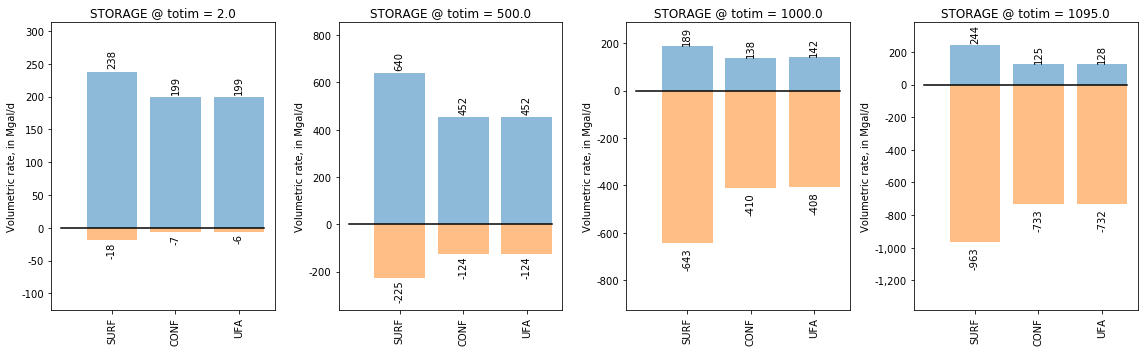

In [21]:
fig = plt.figure(figsize=(16, 5))

times = [2., 500., 1000., 1095.]

for idx, t in enumerate(times):

    ax = fig.add_subplot(1, len(times), idx + 1)

    zb = flopy.utils.ZoneBudget(cbc_f, zon, kstpkper=None, totim=t, aliases=aliases)

    recname = 'STORAGE'
    values_in = zb.get_dataframes(names='FROM_{}'.format(recname)).T.squeeze()
    values_out = zb.get_dataframes(names='TO_{}'.format(recname)).T.squeeze() * -1
    labels = values_in.index.tolist()

    rects_in, rects_out = volumetric_budget_bar_plot(values_in, values_out, labels, ax=ax)

    plt.ylabel('Volumetric rate, in Mgal/d')
    plt.title('{} @ totim = {}'.format(recname, t))

plt.tight_layout()
plt.show()